# The most generic form of a transformation

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
grey = r'albert-einstein_gray.jpg'
colour = r'tulips.jpg'
I_grey = cv2.imread(grey, cv2.IMREAD_GRAYSCALE)
I_BGR = cv2.imread(colour)
numRows = I_grey.shape[0]
numCols = I_grey.shape[1]

In [61]:
# interpolating pixel intensity
def f_bilinearInterpolate(r,c,I):  # function which takes row, colum and source image
    lc = int(c)   # left colum from point, int rounds down to left
    rc = lc + 1   # right colum from point
    wr = c - lc   # weighting for the right colum
    wl = rc - c
    tr = int(r)   # top row
    br = tr + 1   # bottom row
    wt = br - r
    wb = r - tr
    if tr >= 0 and br < I.shape[0] and lc >=0 and rc < I.shape[1]:
        a = wl*I[tr,lc] + wr*I[tr,rc] # intensity of interpolated top row
        b = wl*I[br,lc] + wr*I[br,rc] # intensity of interpolated bottom row
        g = wt*a + wb*b   # intensity of the second interpolation
        return np.uint8(g)
    else: 
        return 0

In [83]:
a = 30
cosa = np.cos(np.deg2rad(a))
sina = np.sin(np.deg2rad(a))
R = np.array([[cosa,-sina,0],[sina,cosa,0],[0,0,1]]) # rotation matrix
T = np.array([[1,0,-300],[0,1,-400],[0,0,1]]) # translation
Sh = np.array([[1,0.5,0],[0,1,0],[0,0,1]]) # shear
S = np.array([[1.3,0,0],[0,0.7,0],[0,0,1]]) # scale
A = np.linalg.inv(T).dot(S).dot(R).dot(Sh).dot(T) # transformation matrix
F = A
F[2,:]=np.array([0.001,0.0001,1])  # changing third row of resultant matrix so that it is now projective

In [85]:
def f_getExtentsProjective(T,I_grey): # receives transformation matrix and source image
    rMax = I_grey.shape[0]
    cMax = I_grey.shape[1]
    coords = np.array([[0,0,1],[0,cMax-1,1],[rMax-1,0,1],[rMax-1,cMax-1,1]])
    A_dash = T.dot(coords.T)
    A_dash = A_dash/A_dash[2,:] # dividing by third row, converting back to non-homogenous coordinates
    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)
    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))
    H,W = maxR-minR+1,maxC-minC+1
    return minR,minC,maxR,maxC,H,W

In [87]:
def f_transformProjective(T,I_grey):
    rMax,cMax = I_grey.shape[0],I_grey.shape[1]
    minR,minC,maxR,maxC,H,W = f_getExtentsProjective(T,I_grey)
    I2 = np.zeros((H,W), dtype = 'uint8')
    Tinv = np.linalg.inv(T)
    for new_i in range(minR,maxR):
        for new_j in range(minC,maxC):
            p_dash = np.array([new_i,new_j,1])
            p = Tinv.dot(p_dash)
            p = p/p[2] # dividing by third row
            i, j = p[0], p[1]
            if i < 0 or i >= numRows or j < 0 or j >= numCols:
                pass
            else:
                g = f_bilinearInterpolate(i,j,I_grey)
                I2[new_i-minR,new_j-minC] = g
    return I2

In [89]:
I2 = f_transformProjective(F,I_grey)

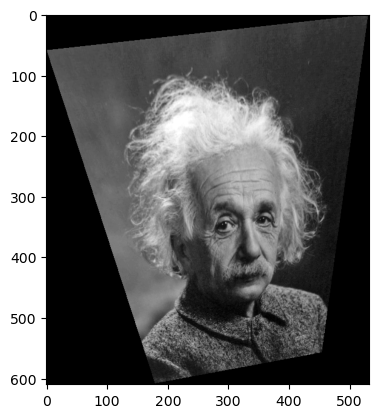

In [90]:
plt.imshow(I2,cmap = 'gray')

In [93]:
plt.imsave(r"projective_transformed.jpg", I2, cmap = "gray")

# Can use this code for any sequence of transformations 